# Exercice 2: Learning a WGAN for synthetic 2-dimensional datasets

<br/><br/><br/><br/>

This practical session contains
- "QUESTION" fields in the text, that you should answer
- blocks of code that you should complete at every region marked with ### ... ###

We advise you to open the notebook on Google Colab.

### Imports

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

# If you don't want to bother with the device, stay on cpu:
# device = torch.device('cpu')

print(device)

cpu


### Target Measure

In the following cell, we define the discrete target measure $\nu$ that will serve as dataset for this practical session.

The variable `xgrid` contains a grid of points that will be useful below to display the discriminators along training.

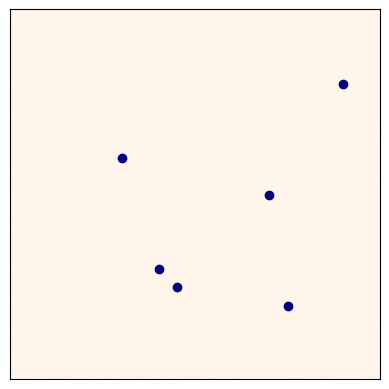

In [22]:
d = 2   # dimension of the data points

# First dataset with 6 points
n = 6
y = torch.zeros((n,d), device=device)
y[0, 0] = 0.9
y[0, 1] = 0.2
y[1, 0] = 0.75
y[1, 1] = 0.8
y[2, 0] = 0.3
y[2, 1] = 0.4
y[3, 0] = 0.4
y[3, 1] = 0.7
y[4, 0] = 0.45
y[4, 1] = 0.75
y[5, 0] = 0.7
y[5, 1] = 0.5

# # Second dataset with 100 points
# n = 100
# t = torch.pi*torch.linspace(-.2,1.2,n)
# y = .05*torch.randn((n,d))
# y[:,0] += torch.cos(t)
# y[:,1] += torch.sin(2*t)
# y = .5 + .3*y
# y = y.to(device)

# Define masses (empirical measure on the data points)
nu = torch.ones(n, device=device)/n

# generate grid for plotting purpose
nr,nc = 256,256
extent = ((-0.5/nc, 1-0.5/nc, 1-0.5/nr, -0.5/nr))
xs = torch.linspace(0, 1, steps=nr)
ys = torch.linspace(0, 1, steps=nc)
xm, ym = torch.meshgrid(xs, ys, indexing='ij')
xm = xm.T
ym = ym.T
xgrid = torch.cat((xm.reshape(nr*nc,1),ym.reshape(nr*nc,1)),1).to(device)

# Plot data points
fig = plt.figure(dpi=100)
plt.xticks([])
plt.yticks([])
plt.imshow(np.zeros((nr,nc)),cmap = 'Oranges', extent=extent) # background
plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
plt.show()

## Define Generator architecture

QUESTION: Examine the layers and parameters of the following generative network.

Write a short description of the architecture of this network.

In [23]:
class Generator(torch.nn.Module):

    def __init__(self, n_in, n_out, n_hid=10, nlayers=3, device=torch.device("cpu")):
        super(Generator, self).__init__()

        self.n_in = n_in
        self.n_out = n_out
        self.n_hid = n_hid
        self.nlayers = nlayers
        self.hidden = nn.ModuleList()

        for n in range(nlayers):
            n_in_t = n_in if n==0 else n_hid
            self.hidden.append(nn.Sequential(
            nn.Linear(n_in_t, n_hid),
            nn.ELU(1)
        ).to(device))

        self.out = nn.Sequential(
            nn.Linear(n_hid, n_out),
            nn.Sigmoid()
        ).to(device)

        self.apply(self._init_weights)


    def forward(self, x):
        for n in range(self.nlayers):
            x = self.hidden[n](x)
        x = self.out(x)
        return x


    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight, 1.0)
            if module.bias is not None:
                module.bias.data.zero_()


QUESTION: Plot one initial configuration of the generator (draw a batch of generated points)

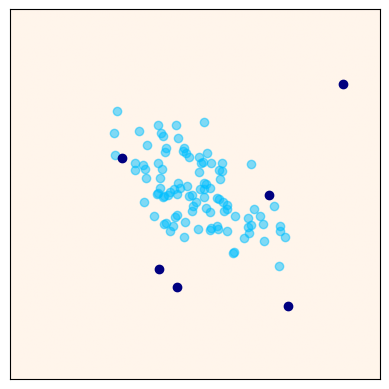

In [24]:
torch.manual_seed(0)  # initialize random seed for reproducibility

n_in = 10    # dimension of the input noise
b = 100      # batch size

# Initialize generator
G = Generator(n_in=n_in, n_out=d, n_hid=100, nlayers=3, device=device)

# Draw a batch x of generated points
#    Input noise z : standard normal with shape (b, n_in)

z = torch.randn(b, n_in, device=device)
x = G(z)

# Plot
xd = x.detach()
fig = plt.figure(dpi=100)
plt.xticks([])
plt.yticks([])
plt.imshow(np.zeros((nr,nc)),cmap = 'Oranges', extent=extent) # background
plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
plt.show()

## Define Discriminator Architecture

In [25]:
class Discriminator(nn.Module):
  def __init__(self, n_in, n_hid=10):
    super(Discriminator, self).__init__()

    self.n_hid = n_hid
    self.n_in = n_in

    self.fc1 = nn.Linear(n_in, n_hid)
    self.fc2 = nn.Linear(n_hid, n_hid)
    self.fc3 = nn.Linear(n_hid, 1)

  def forward(self, x):
    y = nn.LeakyReLU(negative_slope=0.2)(self.fc1(x))
    y = nn.LeakyReLU(negative_slope=0.2)(self.fc2(y))
    y = self.fc3(y)
    return y

## Discriminator training with Weight clipping

QUESTION: For a fixed generator, train the discriminator with WGAN loss and weight clipping.

Try changing the clip_value. What do you observe?

ANSWER: The clip_value directly controls the Lipschitz constraint by forcing the weights of the discriminator to stay within a fixed range. Too small constrains D too much; too large weakens the constraint and breaks the theoretical grounding of WGAN.

[0/1000], -0.007124


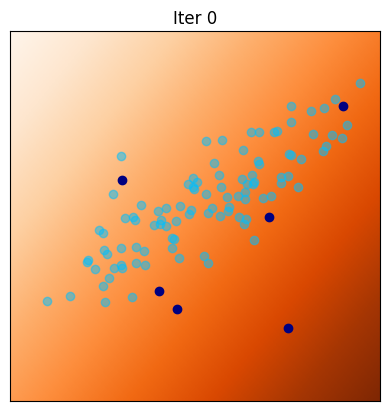

[100/1000], -0.006148


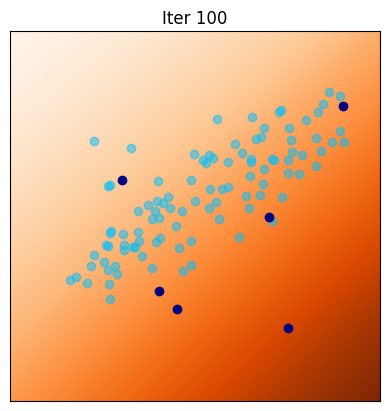

[200/1000], -0.007020


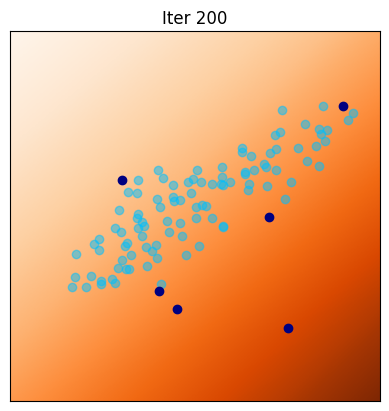

[300/1000], -0.006355


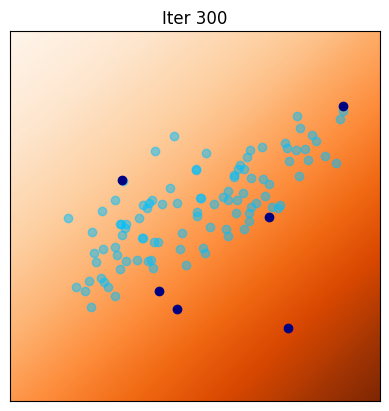

[400/1000], -0.006726


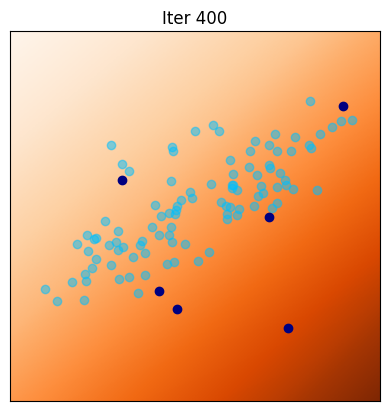

[500/1000], -0.005548


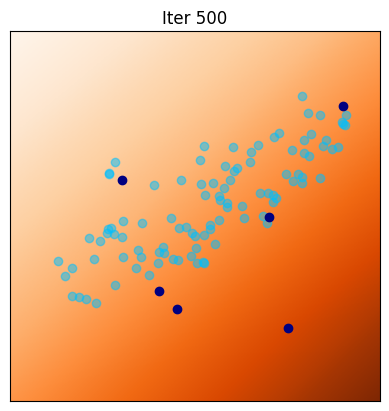

[600/1000], -0.007900


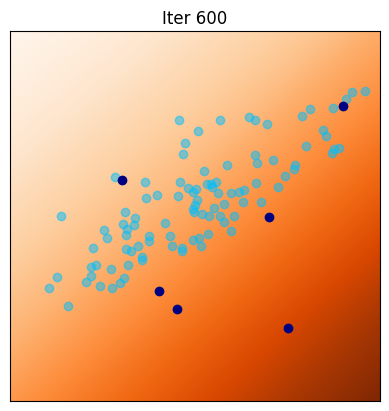

[700/1000], -0.007664


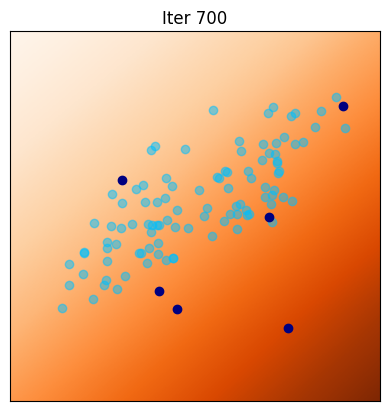

[800/1000], -0.008368


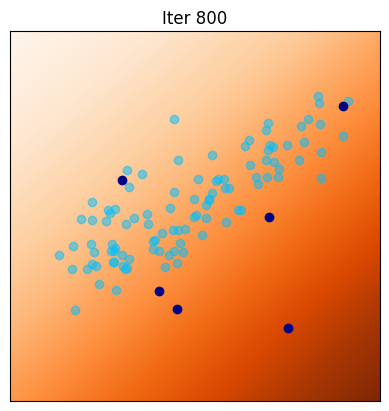

[900/1000], -0.007576


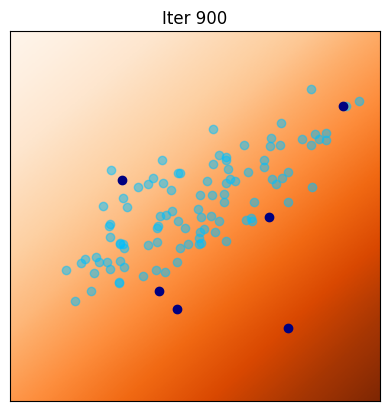

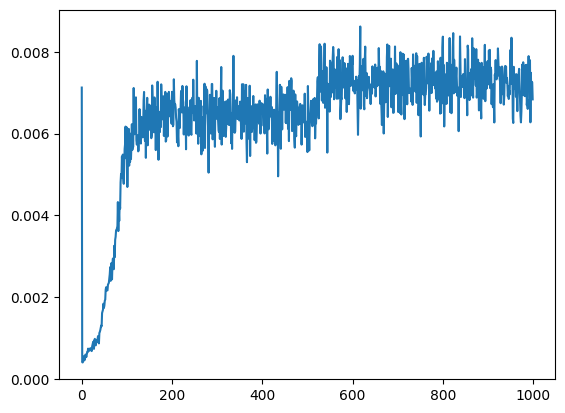

In [26]:
torch.manual_seed(1)  # initialize random seed for reproducibility

# fix one generator
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)

# parameters for discriminator optimization
lrdisc = 0.002
beta_1 = 0.5
beta_2 = 0.999
niterD=1000

clip_value = .1

D = Discriminator(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))

iter_display = 100  # display current configuration each iter_display iteration

# Lists to keep track of progress
Dlosses = []

for iter in range(0,niterD):

    ### UPDATE OF D ###
    optimD.zero_grad()

    z = torch.randn(b, n_in, device=device)
    x = G(z)
    x.requires_grad_()

    Dx = D(x).view(-1)

    Dloss = torch.mean(Dx) - torch.mean(D(y).view(-1))

    Dloss.backward()

    optimD.step()

    ### ... Weight Clipping ... ###
    for p in D.parameters():
        p.data.clamp_(-clip_value, clip_value)

    ### SAVE LOSS ###
    Dlosst = Dloss.item()
    Dlosses.append(-Dlosst)

    if(iter%iter_display == 0):
        print('[%d/%d], %f' % (iter, niterD, Dlosst))
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Iter '+str(iter)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)  # discriminator
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()

plt.plot(Dlosses)

## Estimate the Lipschitz constant of the discriminator

The following function computes a lower bound of the Lipschitz constant of $D$ on points that are interpolated between $x$ and $y$.

NB: If $x$ and $y$ do not have the same number of points, we discard the last points.
In comment, we give an alternative code that allows to compute all segments $[x_i, y_j]$ (but it is, of course, slower that just computing segments $[x_i, y_i]$).

In [27]:
def lipconstant(D,x,y):
    b = x.shape[0]
    n = y.shape[0]
    # shrink vectors if they are too large
    if n>b:
        y = y[0:b,:]
        n = b
    else:
        x = x[0:n,:]
        b = n
    # compute interpolated points
    alpha = torch.rand((b,1),device=device)
    interp = alpha * y + (1 - alpha) * x
    interp.requires_grad_()

    # Calculate probability of interpolated examples
    Di = D(interp).view(-1)

    # Calculate gradients of probabilities with respect to examples
    gradout = torch.ones(Di.size()).to(device)
    gradients = torch.autograd.grad(outputs=Di, inputs=interp, grad_outputs=gradout,
       create_graph=True, retain_graph=True)[0]

    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1))

    # Return gradient penalty
    return torch.mean(gradients_norm)

#     # Calculate interpolation
#     b = x.shape[0]
#     n = y.shape[0]
#     alpha = torch.rand((b,n,1),device=device)
#     interp = (alpha * y[None,:,:] + (1 - alpha) * x[:,None,:]).flatten(end_dim=1)
#     interp.requires_grad_()


QUESTION: Use this function to examine the Lipschitz constant of the final discriminator obtained above with weight clipping.


In [28]:
lipconstant(D,x,y)

tensor(0.0578, grad_fn=<MeanBackward0>)

## Gradient Penalty

QUESTION: Implement a function computing the gradient penalty of a discriminator $D$ on points $X$ that are randomly interpolated between $x$ and $y$:
$$ GP(D) = \mathbb{E}\left[ \Big(\|\nabla D(X)\| - 1 \Big)^2 \right] .$$
In pratice you will use
$$\|\nabla D(X)\| \approx \sqrt{\|\nabla D (X)\|_2^2 + 10^{-12} } $$
to avoid numerical instability.

In [14]:
def gradient_penalty(D,x,y):
    b = x.shape[0]
    n = y.shape[0]
    # shrink vectors if they are too large
    if n>b:
        y = y[0:b,:]
        n = b
    else:
        x = x[0:n,:]
        b = n
    # compute interpolated points
    alpha = torch.rand((b,1),device=device)
    interp = (alpha * y + (1 - alpha) * x)
    interp.requires_grad_()

#     # Calculate interpolation
#     b = x.shape[0]
#     n = y.shape[0]
#     alpha = torch.rand((b,n,1),device=device)
#     interp = (alpha * y[None,:,:] + (1 - alpha) * x[:,None,:]).flatten(end_dim=1)
#     interp.requires_grad_()

    # Calculate probability of interpolated examples
    Di = D(interp).view(-1)

    # Calculate gradients of probabilities with respect to examples
    gradout = torch.ones(Di.size()).to(device)
    gradients = torch.autograd.grad(outputs=Di, inputs=interp, grad_outputs=gradout,
       create_graph=True, retain_graph=True)[0]

    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 10e-12)

    # Return gradient penalty
    return ((gradients_norm - 1) ** 2).mean()
#     return ((gradients_norm - 1) ** 2*(gradients_norm>1)).mean()

print(gradient_penalty(D,x,y))

tensor(0.8878, grad_fn=<MeanBackward0>)


## Discriminator training with Gradient Penalty

QUESTION: Complete the following code at the blocks ###...###.

Adjust the weight of the gradient penalty (parameter `gpw`) to get a Lipschitz constant $\approx 1$.

[0/1000], Dloss=8.5581, Lip(D)=0.0817


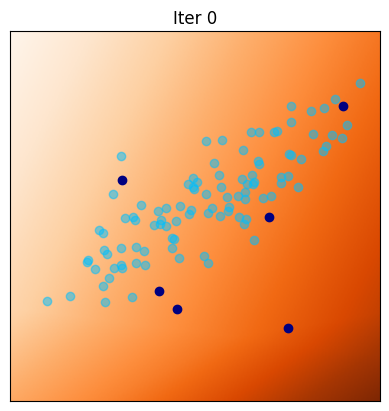

[100/1000], Dloss=0.1103, Lip(D)=0.9815


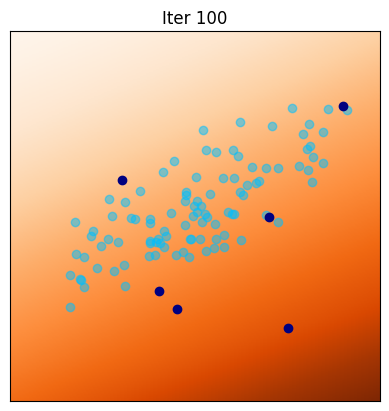

[200/1000], Dloss=0.1113, Lip(D)=0.9907


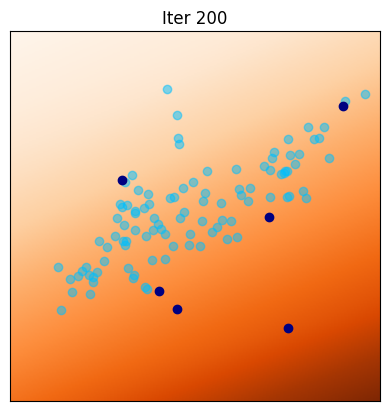

[300/1000], Dloss=0.1116, Lip(D)=0.9958


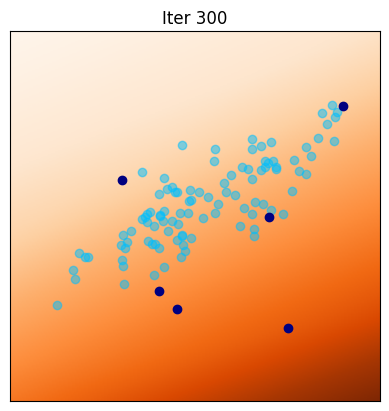

[400/1000], Dloss=0.1026, Lip(D)=0.9947


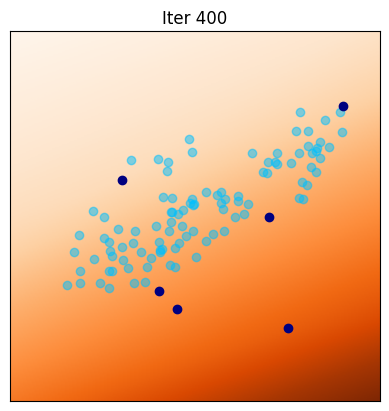

[500/1000], Dloss=0.1216, Lip(D)=0.9929


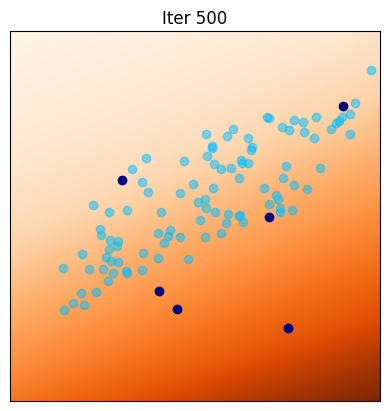

[600/1000], Dloss=0.1174, Lip(D)=1.0023


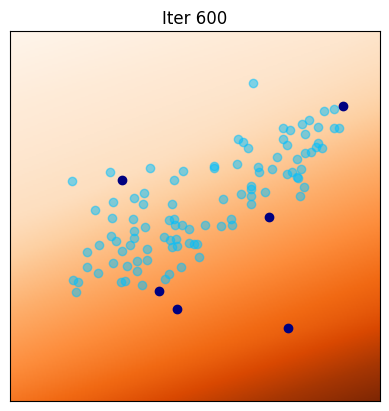

[700/1000], Dloss=0.1203, Lip(D)=0.9873


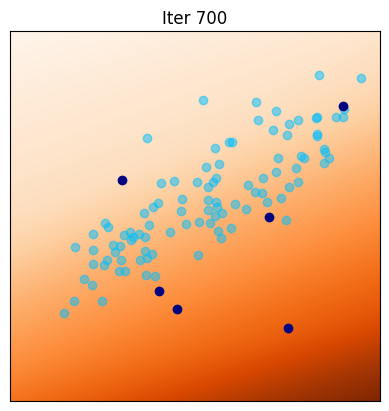

[800/1000], Dloss=0.1419, Lip(D)=0.9907


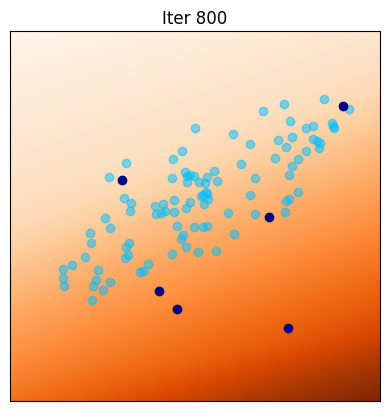

[900/1000], Dloss=0.1227, Lip(D)=0.9998


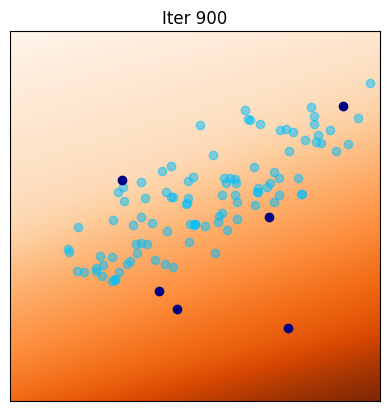

Final estimated Lipschitz constant =  0.9033222794532776


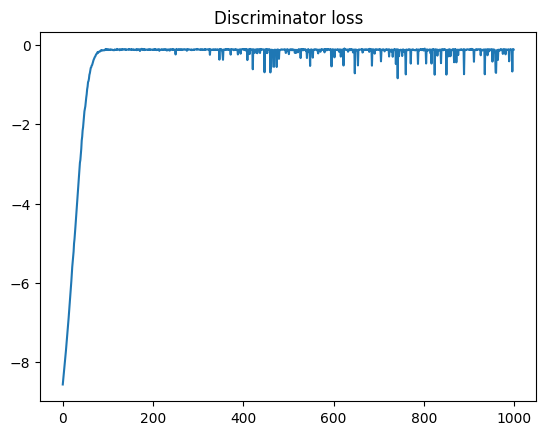

In [15]:
torch.manual_seed(1)  # initialize random seed for reproducibility

# Initialize generators and discriminators
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
D = Discriminator(n_in=d, n_hid=10).to(device)

# parameters for training
lrdisc = 0.002
beta_1 = 0.5
beta_2 = 0.999
niterD=1000
gpw = 10       # parameter for gradient penalty

optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))


iter_display = 100  # display current configuration each iter_display iteration

# Lists to keep track of progress
Dlosses = []

for iter in range(0,niterD):

    ### UPDATE OF D ###

    optimD.zero_grad()
    z = torch.randn(b, n_in, device=device)
    x = G(z)
    x.requires_grad_()

    Dx = D(x).view(-1)

    Dloss = -torch.mean(Dx) + torch.mean(D(y).view(-1)) + gpw * gradient_penalty(D,x,y)

    Dloss.backward()

    optimD.step()

    ### SAVE LOSS ###
    Dlosst = Dloss.item()
    Dlosses.append(-Dlosst)

    if(iter%iter_display == 0):
        print('[%d/%d], Dloss=%.4f, Lip(D)=%.4f' % (iter, niterD, Dlosst,lipconstant(D,x,y).item()))
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Iter '+str(iter)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)  # discriminator
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()

print('Final estimated Lipschitz constant = ',lipconstant(D,x,y).item())

plt.figure(dpi=100)
plt.plot(Dlosses)
plt.title('Discriminator loss')
plt.show()

## WGAN-GP training

QUESTION: Complete the following code in order to train simultaneously the generator and discriminator.

You will alternate `niterD` iterations on the discriminator and `niterG` iterations of the discriminator.

[1/100] 	Loss_D: -0.1774	Loss_G: -1.7155	Lip(D)=1.5483
[2/100] 	Loss_D: -0.1468	Loss_G: -1.0114	Lip(D)=1.6655
[3/100] 	Loss_D: -0.1586	Loss_G: -1.8094	Lip(D)=1.4862
[4/100] 	Loss_D: -0.0758	Loss_G: -2.9432	Lip(D)=1.4716
[5/100] 	Loss_D: -0.1567	Loss_G: -9.9449	Lip(D)=1.3871


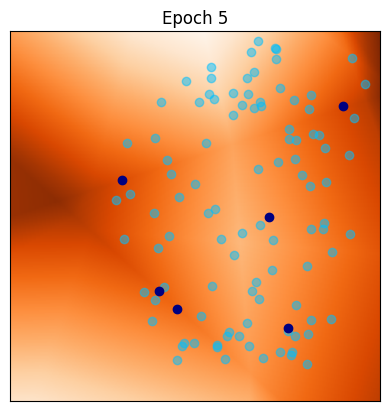

[6/100] 	Loss_D: -0.1790	Loss_G: -11.8595	Lip(D)=1.6879
[7/100] 	Loss_D: -0.1835	Loss_G: -13.2037	Lip(D)=1.6327
[8/100] 	Loss_D: -0.0796	Loss_G: -16.8019	Lip(D)=1.4225
[9/100] 	Loss_D: -0.1279	Loss_G: -18.4810	Lip(D)=1.3627
[10/100] 	Loss_D: -0.0791	Loss_G: -20.8588	Lip(D)=1.4065


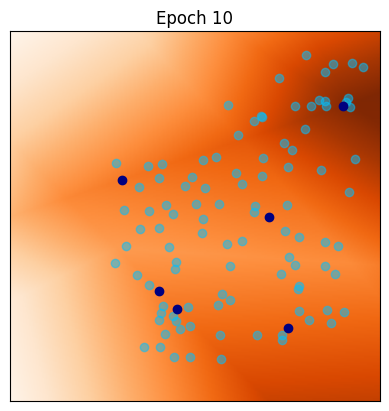

[11/100] 	Loss_D: -0.0570	Loss_G: -21.9279	Lip(D)=1.2086
[12/100] 	Loss_D: -0.1523	Loss_G: -22.7519	Lip(D)=1.3769
[13/100] 	Loss_D: -0.0599	Loss_G: -24.3057	Lip(D)=1.2726
[14/100] 	Loss_D: -0.0985	Loss_G: -26.6225	Lip(D)=1.1749
[15/100] 	Loss_D: -0.1030	Loss_G: -29.4388	Lip(D)=1.2864


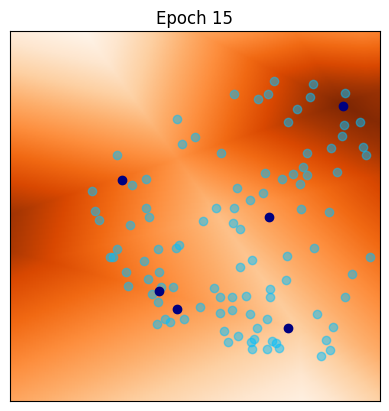

[16/100] 	Loss_D: -0.0176	Loss_G: -29.1610	Lip(D)=1.2943
[17/100] 	Loss_D: -0.0708	Loss_G: -28.6572	Lip(D)=1.2536
[18/100] 	Loss_D: -0.1101	Loss_G: -28.8532	Lip(D)=1.4730
[19/100] 	Loss_D: -0.1040	Loss_G: -34.4979	Lip(D)=1.4008
[20/100] 	Loss_D: -0.0713	Loss_G: -40.3300	Lip(D)=1.6161


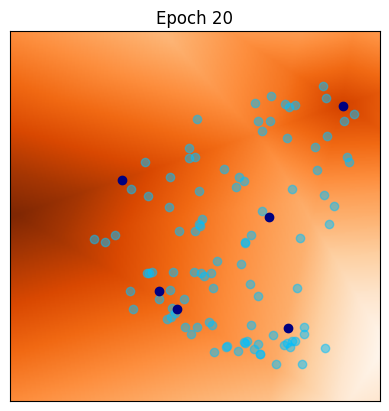

[21/100] 	Loss_D: -0.0854	Loss_G: -39.9409	Lip(D)=1.2818
[22/100] 	Loss_D: -0.0922	Loss_G: -39.1571	Lip(D)=1.1976
[23/100] 	Loss_D: -0.0885	Loss_G: -39.2261	Lip(D)=1.2197
[24/100] 	Loss_D: -0.0596	Loss_G: -44.6928	Lip(D)=1.5569
[25/100] 	Loss_D: -0.0719	Loss_G: -47.3009	Lip(D)=1.5110


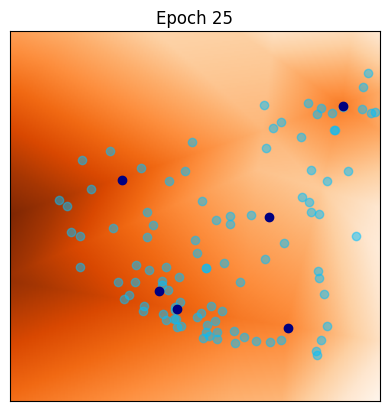

[26/100] 	Loss_D: -0.0668	Loss_G: -45.4400	Lip(D)=1.1277
[27/100] 	Loss_D: -0.0684	Loss_G: -45.5896	Lip(D)=1.2790
[28/100] 	Loss_D: -0.0667	Loss_G: -51.3511	Lip(D)=1.3565
[29/100] 	Loss_D: -0.0369	Loss_G: -54.1100	Lip(D)=1.3098
[30/100] 	Loss_D: -0.0576	Loss_G: -53.4701	Lip(D)=1.3464


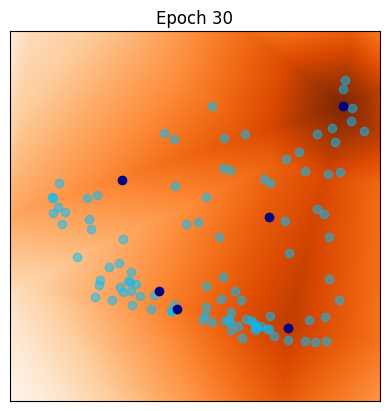

[31/100] 	Loss_D: -0.0500	Loss_G: -55.1330	Lip(D)=1.2404
[32/100] 	Loss_D: -0.0566	Loss_G: -56.0388	Lip(D)=1.3187
[33/100] 	Loss_D: -0.0739	Loss_G: -57.8391	Lip(D)=1.3745
[34/100] 	Loss_D: -0.0681	Loss_G: -64.7810	Lip(D)=1.4511
[35/100] 	Loss_D: -0.0506	Loss_G: -68.8370	Lip(D)=1.1926


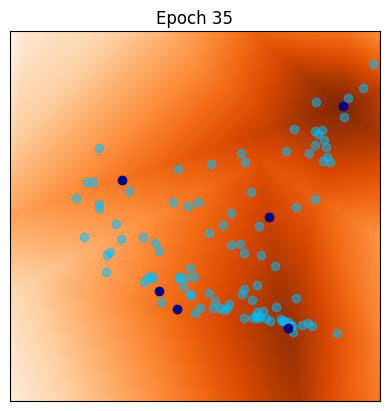

[36/100] 	Loss_D: -0.0936	Loss_G: -68.3492	Lip(D)=1.4487
[37/100] 	Loss_D: -0.0814	Loss_G: -68.3414	Lip(D)=1.3449
[38/100] 	Loss_D: -0.1142	Loss_G: -72.2906	Lip(D)=1.3278
[39/100] 	Loss_D: -0.1030	Loss_G: -74.6016	Lip(D)=1.3021
[40/100] 	Loss_D: -0.0456	Loss_G: -72.8233	Lip(D)=1.2035


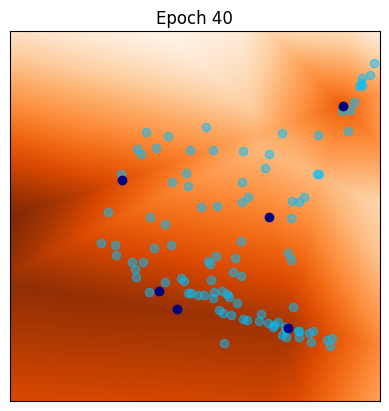

[41/100] 	Loss_D: -0.0823	Loss_G: -75.0938	Lip(D)=1.2464
[42/100] 	Loss_D: -0.0692	Loss_G: -80.8828	Lip(D)=1.2402
[43/100] 	Loss_D: -0.1015	Loss_G: -83.4881	Lip(D)=1.2595
[44/100] 	Loss_D: -0.0777	Loss_G: -86.3838	Lip(D)=1.5418
[45/100] 	Loss_D: -0.0626	Loss_G: -85.2213	Lip(D)=1.1894


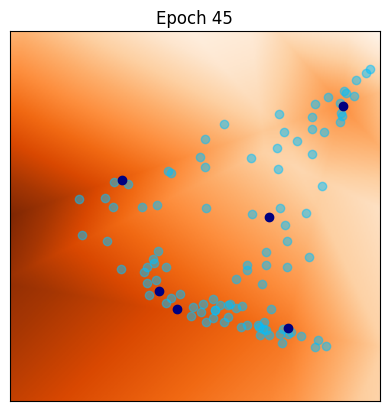

[46/100] 	Loss_D: -0.0520	Loss_G: -86.3631	Lip(D)=1.1300
[47/100] 	Loss_D: -0.0550	Loss_G: -94.7821	Lip(D)=1.6080
[48/100] 	Loss_D: -0.1088	Loss_G: -98.9681	Lip(D)=1.3125
[49/100] 	Loss_D: -0.0763	Loss_G: -98.2073	Lip(D)=1.1972
[50/100] 	Loss_D: -0.1089	Loss_G: -97.3046	Lip(D)=1.3409


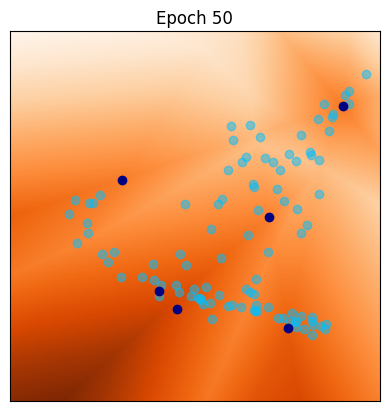

[51/100] 	Loss_D: -0.1103	Loss_G: -102.4962	Lip(D)=1.4492
[52/100] 	Loss_D: -0.0878	Loss_G: -110.0766	Lip(D)=1.4481
[53/100] 	Loss_D: -0.1059	Loss_G: -112.2603	Lip(D)=1.2864
[54/100] 	Loss_D: -0.1232	Loss_G: -113.1373	Lip(D)=1.4785
[55/100] 	Loss_D: -0.1049	Loss_G: -116.3076	Lip(D)=1.4242


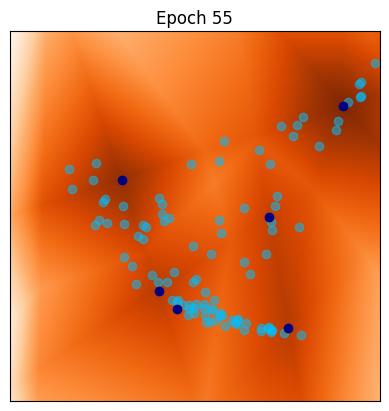

[56/100] 	Loss_D: -0.1104	Loss_G: -119.3168	Lip(D)=1.4092
[57/100] 	Loss_D: -0.1071	Loss_G: -123.3826	Lip(D)=1.1765
[58/100] 	Loss_D: -0.1191	Loss_G: -126.2590	Lip(D)=1.4363
[59/100] 	Loss_D: -0.1187	Loss_G: -124.2504	Lip(D)=1.4181
[60/100] 	Loss_D: -0.0959	Loss_G: -130.4051	Lip(D)=1.4473


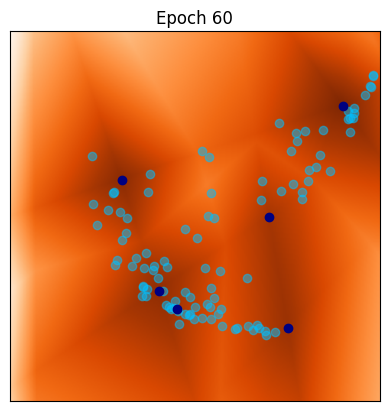

[61/100] 	Loss_D: -0.1107	Loss_G: -134.7494	Lip(D)=1.5292
[62/100] 	Loss_D: -0.1070	Loss_G: -134.8111	Lip(D)=1.4203
[63/100] 	Loss_D: -0.0789	Loss_G: -135.5887	Lip(D)=1.3497
[64/100] 	Loss_D: -0.1174	Loss_G: -138.6314	Lip(D)=1.2277
[65/100] 	Loss_D: -0.0905	Loss_G: -141.6972	Lip(D)=1.5586


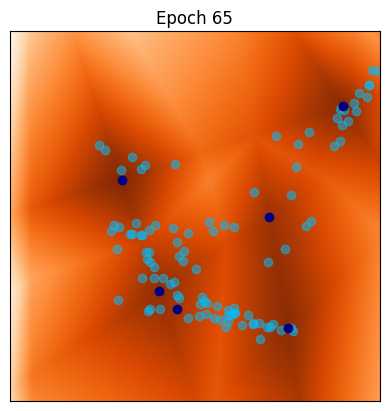

[66/100] 	Loss_D: -0.1060	Loss_G: -142.9547	Lip(D)=1.2947
[67/100] 	Loss_D: -0.1065	Loss_G: -143.6838	Lip(D)=1.3988
[68/100] 	Loss_D: -0.0982	Loss_G: -146.6864	Lip(D)=1.3243
[69/100] 	Loss_D: -0.1113	Loss_G: -145.4674	Lip(D)=1.3711
[70/100] 	Loss_D: -0.0813	Loss_G: -145.4284	Lip(D)=1.4447


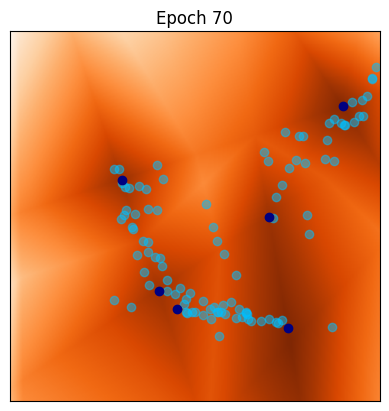

[71/100] 	Loss_D: -0.0676	Loss_G: -151.0534	Lip(D)=1.5430
[72/100] 	Loss_D: -0.0922	Loss_G: -144.7498	Lip(D)=1.6618
[73/100] 	Loss_D: -0.1002	Loss_G: -144.3882	Lip(D)=1.3288
[74/100] 	Loss_D: -0.0869	Loss_G: -145.2592	Lip(D)=1.3575
[75/100] 	Loss_D: -0.1044	Loss_G: -147.3848	Lip(D)=1.2286


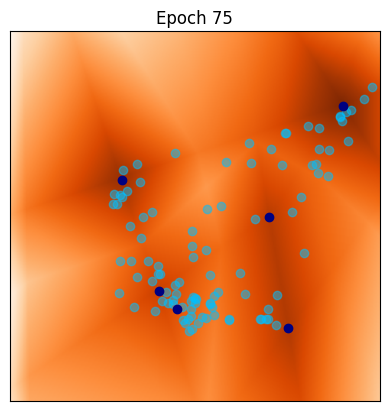

[76/100] 	Loss_D: -0.1123	Loss_G: -152.3747	Lip(D)=1.2625
[77/100] 	Loss_D: -0.0905	Loss_G: -149.7948	Lip(D)=1.4033
[78/100] 	Loss_D: -0.1065	Loss_G: -148.9497	Lip(D)=1.5097
[79/100] 	Loss_D: -0.0809	Loss_G: -148.8326	Lip(D)=1.3502
[80/100] 	Loss_D: -0.1121	Loss_G: -148.2251	Lip(D)=1.3871


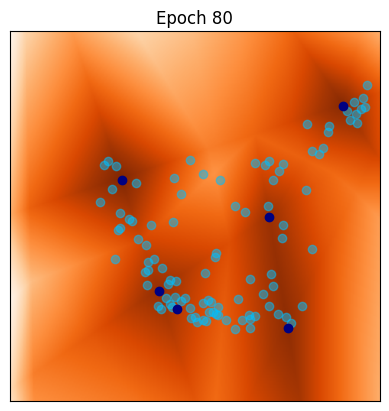

[81/100] 	Loss_D: -0.1019	Loss_G: -150.7282	Lip(D)=1.2149
[82/100] 	Loss_D: -0.0523	Loss_G: -153.5252	Lip(D)=1.2867
[83/100] 	Loss_D: -0.0854	Loss_G: -155.8731	Lip(D)=1.3203
[84/100] 	Loss_D: -0.0804	Loss_G: -155.7535	Lip(D)=1.3065
[85/100] 	Loss_D: -0.0698	Loss_G: -154.3135	Lip(D)=1.5649


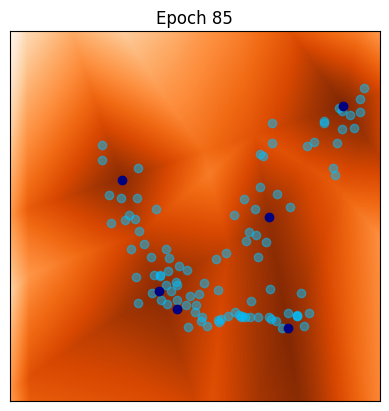

[86/100] 	Loss_D: -0.0725	Loss_G: -153.4541	Lip(D)=1.3078
[87/100] 	Loss_D: -0.0719	Loss_G: -155.2870	Lip(D)=1.4260
[88/100] 	Loss_D: -0.0794	Loss_G: -152.9103	Lip(D)=1.3530
[89/100] 	Loss_D: -0.0898	Loss_G: -151.0429	Lip(D)=1.5655
[90/100] 	Loss_D: -0.1053	Loss_G: -157.5263	Lip(D)=1.4291


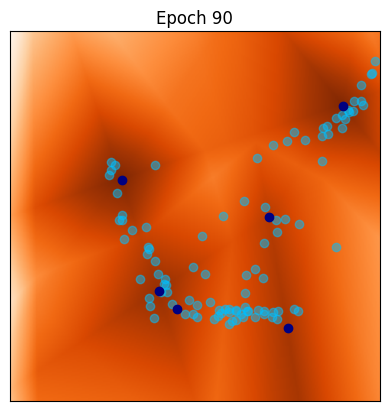

[91/100] 	Loss_D: -0.0873	Loss_G: -154.7244	Lip(D)=1.3371
[92/100] 	Loss_D: -0.0934	Loss_G: -153.2982	Lip(D)=1.2116
[93/100] 	Loss_D: -0.0600	Loss_G: -158.3635	Lip(D)=1.2411
[94/100] 	Loss_D: -0.0800	Loss_G: -161.7406	Lip(D)=1.3480
[95/100] 	Loss_D: -0.0999	Loss_G: -160.1301	Lip(D)=1.3223


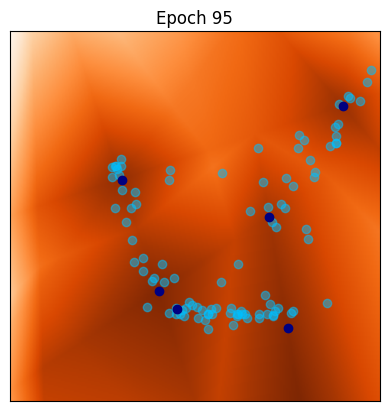

[96/100] 	Loss_D: -0.0886	Loss_G: -159.8949	Lip(D)=1.3536
[97/100] 	Loss_D: -0.0863	Loss_G: -164.6957	Lip(D)=1.3203
[98/100] 	Loss_D: -0.0994	Loss_G: -160.7784	Lip(D)=1.3397
[99/100] 	Loss_D: -0.1030	Loss_G: -165.3544	Lip(D)=1.3119


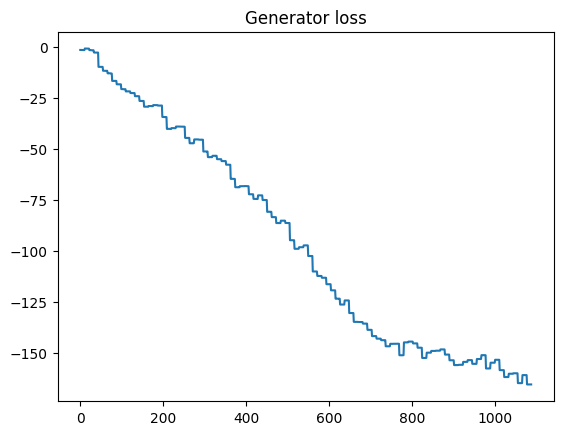

<All keys matched successfully>

In [16]:
## parameters for training
n_epochs = 100
niterD=1000
niterG=10
gpw = .1

lr = 0.002      # learning rate for generator
lrdisc = 0.002  # learning rate for discriminator
beta_1 = 0.5
beta_2 = 0.999

torch.manual_seed(1)  # initialize random seed for reproducibility

# Initialize generators and discriminators
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
optimG = optim.Adam(G.parameters(), lr=lr)

D = Discriminator(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))


Glosses = []
Dlosses = []

iter_display = 5

# Main loop
for epoch in range(1,n_epochs):

    ############################
    ### Train discriminator (niterD iterations)
    ############################

    for iter in range(0,niterD):
      optimD.zero_grad()

      z = torch.randn(b, n_in, device=device)
      x = G(z)
      x.requires_grad_()

      Dx = D(x).view(-1)

      Dloss = torch.mean(Dx) - torch.mean(D(y).view(-1)) + gpw * gradient_penalty(D,x,y)
      Dlosses.append(Dloss.item())

      Dloss.backward()


      optimD.step()

    ############################
    ### Train generator (niterG iterations)
    ############################
    for iter in range(0,niterG):
        optimG.zero_grad()

        z = torch.randn(b, n_in, device=device)
        x = G(z)
        x.requires_grad_()

        Dx = D(x).view(-1)

        Gloss = -torch.mean(Dx)
        Glosses.append(Gloss.item())

        Gloss.backward()

        optimG.step()

    # Output training stats
    print('[%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f\tLip(D)=%.4f'
      % (epoch, n_epochs, Dloss.item(), Gloss.item(),lipconstant(D,x,y).item()))
    Glosses.append(Gloss.item())
    Dlosses.append(Dloss.item())

    if(epoch % iter_display == 0):
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
        z = torch.randn(b, n_in, device=device)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Epoch '+str(epoch)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()


plt.figure(dpi=100)
plt.plot(Glosses)
plt.title('Generator loss')
plt.show()

# Save final generator for later use
wgan = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
wgan.load_state_dict(G.state_dict())

## Sensitivy to hyper-parameters

QUESTION: Repeat the WGAN learning experiment, by changing the parameters of the optimization (learning rates, number of updates of D and G, etc).

From your experiments, can you draw a few recommendations for stable training?

ANSWER:

- Learning Rates (lrdisc and lr)
It is generally advisable for the generator’s learning rate to be slightly lower than or equal to that of the discriminator. This practice contributes to training stability. Typical values for both learning rates range between 0.0001 and 0.0002.

- Discriminator/Generator Update Frequency (niterD and niterG)
Updating the discriminator more frequently than the generator helps maintain its effectiveness, which is critical for stable adversarial training. A common strategy is to perform five discriminator updates for every generator update.

- Gradient Penalty Weight (gpw)
A gradient penalty weight of 1 is commonly used, as it effectively enforces the Lipschitz constraint without introducing vanishing gradients. Lower values may reduce the regularization effect, while excessively high values can destabilize the training process.

[1/100] 	Loss_D: -0.1309	Loss_G: -2.1261	Lip(D)=1.0574
[2/100] 	Loss_D: -0.6530	Loss_G: -1.5295	Lip(D)=1.2830
[3/100] 	Loss_D: -0.4790	Loss_G: -3.1718	Lip(D)=1.2164
[4/100] 	Loss_D: -0.2531	Loss_G: -4.8693	Lip(D)=1.1441
[5/100] 	Loss_D: -0.1777	Loss_G: -3.2510	Lip(D)=0.9867


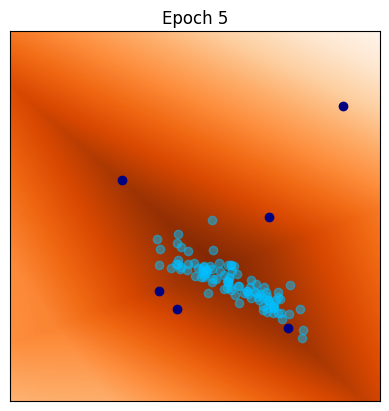

[6/100] 	Loss_D: -0.2117	Loss_G: -0.5837	Lip(D)=1.1719
[7/100] 	Loss_D: -0.3649	Loss_G: -3.0183	Lip(D)=1.1397
[8/100] 	Loss_D: -0.5230	Loss_G: -3.9143	Lip(D)=1.2282
[9/100] 	Loss_D: -0.3760	Loss_G: -5.0347	Lip(D)=1.1992
[10/100] 	Loss_D: -0.2506	Loss_G: -8.0818	Lip(D)=0.9146


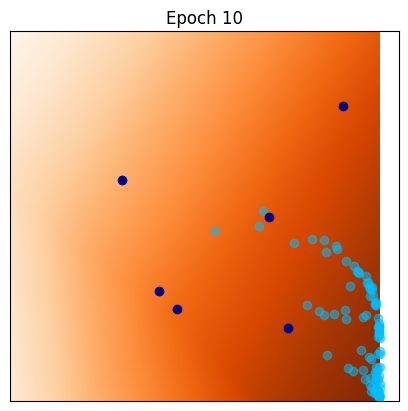

[11/100] 	Loss_D: -0.5013	Loss_G: -7.8559	Lip(D)=1.2213
[12/100] 	Loss_D: -0.2851	Loss_G: -8.0185	Lip(D)=1.1168
[13/100] 	Loss_D: -0.2847	Loss_G: -7.3499	Lip(D)=1.1417
[14/100] 	Loss_D: -0.1577	Loss_G: -16.3651	Lip(D)=1.0452
[15/100] 	Loss_D: -0.4045	Loss_G: -12.9642	Lip(D)=1.1826


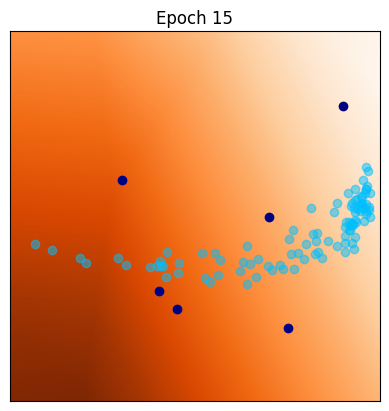

[16/100] 	Loss_D: -0.1295	Loss_G: -14.7506	Lip(D)=0.9894
[17/100] 	Loss_D: -0.2756	Loss_G: -13.0931	Lip(D)=1.1683
[18/100] 	Loss_D: -0.2949	Loss_G: -16.9107	Lip(D)=1.1765
[19/100] 	Loss_D: -0.2371	Loss_G: -16.5304	Lip(D)=1.1410
[20/100] 	Loss_D: -0.0066	Loss_G: -19.1796	Lip(D)=0.9942


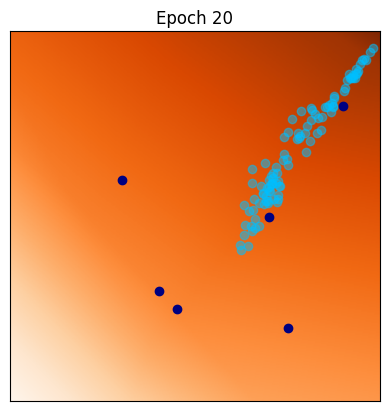

[21/100] 	Loss_D: -0.3376	Loss_G: -19.5998	Lip(D)=1.1512
[22/100] 	Loss_D: -0.0994	Loss_G: -20.7282	Lip(D)=1.0450
[23/100] 	Loss_D: -0.2526	Loss_G: -15.1375	Lip(D)=1.1206
[24/100] 	Loss_D: -0.0650	Loss_G: -19.2181	Lip(D)=1.0298
[25/100] 	Loss_D: -0.1614	Loss_G: -17.6813	Lip(D)=1.0725


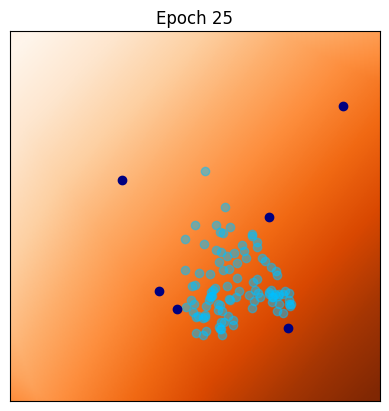

[26/100] 	Loss_D: -0.1537	Loss_G: -18.8314	Lip(D)=1.0829
[27/100] 	Loss_D: -0.1218	Loss_G: -21.2429	Lip(D)=1.0643
[28/100] 	Loss_D: -0.0825	Loss_G: -17.9140	Lip(D)=1.0365
[29/100] 	Loss_D: -0.0069	Loss_G: -18.1685	Lip(D)=0.9982
[30/100] 	Loss_D: -0.1999	Loss_G: -22.8148	Lip(D)=1.0928


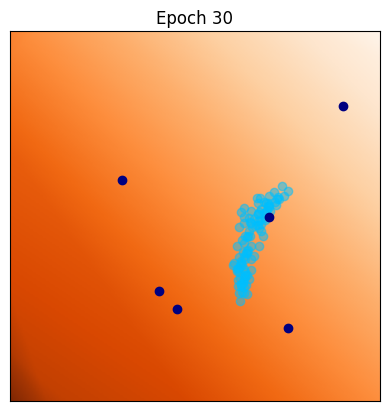

[31/100] 	Loss_D: -0.0773	Loss_G: -23.1605	Lip(D)=1.0416
[32/100] 	Loss_D: -0.1890	Loss_G: -18.4565	Lip(D)=1.0939
[33/100] 	Loss_D: -0.0553	Loss_G: -21.2254	Lip(D)=1.0315
[34/100] 	Loss_D: -0.0794	Loss_G: -23.3781	Lip(D)=1.0394
[35/100] 	Loss_D: -0.0112	Loss_G: -26.3167	Lip(D)=1.0029


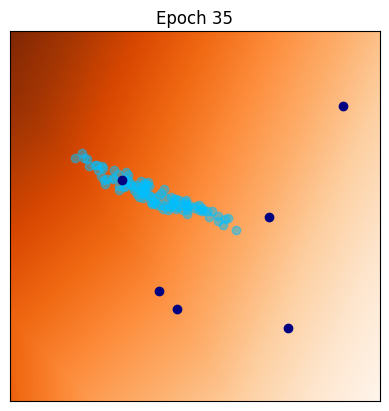

[36/100] 	Loss_D: -0.2202	Loss_G: -22.9193	Lip(D)=1.1052
[37/100] 	Loss_D: -0.0507	Loss_G: -23.7518	Lip(D)=1.0238
[38/100] 	Loss_D: -0.1011	Loss_G: -29.2016	Lip(D)=1.0492
[39/100] 	Loss_D: -0.0425	Loss_G: -30.8068	Lip(D)=1.0250
[40/100] 	Loss_D: -0.1201	Loss_G: -26.4196	Lip(D)=1.0776


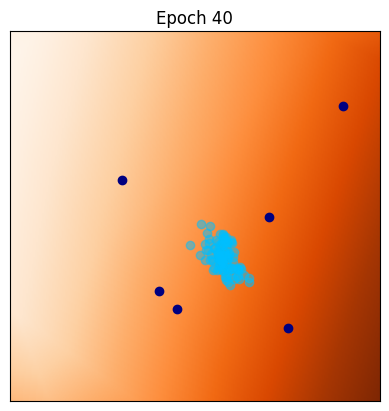

[41/100] 	Loss_D: -0.2584	Loss_G: -30.4633	Lip(D)=1.1115
[42/100] 	Loss_D: -0.2728	Loss_G: -31.4964	Lip(D)=1.1519
[43/100] 	Loss_D: -0.2811	Loss_G: -30.0600	Lip(D)=1.1323
[44/100] 	Loss_D: -0.3733	Loss_G: -39.8017	Lip(D)=1.1156
[45/100] 	Loss_D: -0.2774	Loss_G: -41.8630	Lip(D)=1.1092


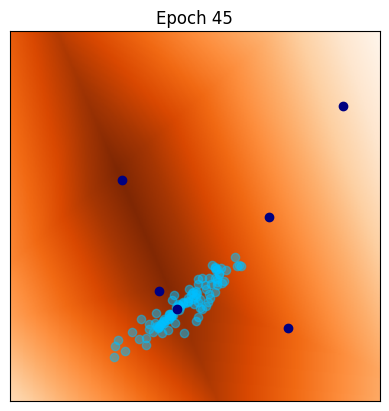

[46/100] 	Loss_D: -0.2338	Loss_G: -35.5544	Lip(D)=1.0048
[47/100] 	Loss_D: -0.3139	Loss_G: -39.8929	Lip(D)=1.1481
[48/100] 	Loss_D: -0.0733	Loss_G: -36.9197	Lip(D)=1.0179
[49/100] 	Loss_D: -0.2672	Loss_G: -37.7769	Lip(D)=1.1004
[50/100] 	Loss_D: -0.1356	Loss_G: -39.9150	Lip(D)=1.0513


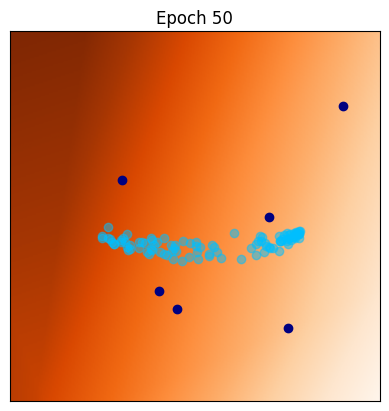

[51/100] 	Loss_D: -0.1845	Loss_G: -42.6421	Lip(D)=1.0166
[52/100] 	Loss_D: -0.4378	Loss_G: -51.7079	Lip(D)=1.7792
[53/100] 	Loss_D: -0.5347	Loss_G: -31.4723	Lip(D)=1.1357
[54/100] 	Loss_D: -0.4378	Loss_G: -21.7397	Lip(D)=1.1248
[55/100] 	Loss_D: -0.3455	Loss_G: -35.2666	Lip(D)=1.2098


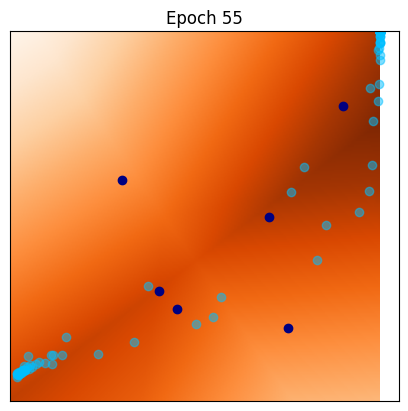

[56/100] 	Loss_D: -0.4400	Loss_G: -49.3841	Lip(D)=1.1618
[57/100] 	Loss_D: -0.2016	Loss_G: -50.5667	Lip(D)=1.0582
[58/100] 	Loss_D: -0.2271	Loss_G: -60.3790	Lip(D)=1.1386
[59/100] 	Loss_D: -0.3831	Loss_G: -25.8415	Lip(D)=1.1811
[60/100] 	Loss_D: -0.2104	Loss_G: -14.5548	Lip(D)=1.0992


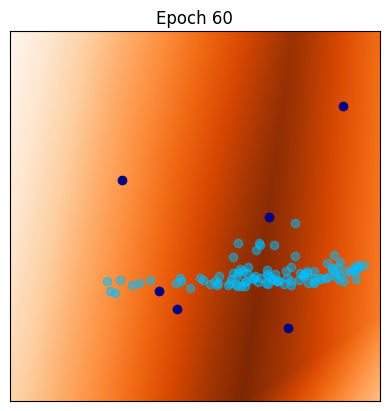

[61/100] 	Loss_D: -0.2065	Loss_G: -19.2823	Lip(D)=1.0717
[62/100] 	Loss_D: -0.5309	Loss_G: -31.1737	Lip(D)=1.2371
[63/100] 	Loss_D: -0.2474	Loss_G: -31.1235	Lip(D)=1.0346
[64/100] 	Loss_D: -0.2526	Loss_G: -43.7910	Lip(D)=1.1129
[65/100] 	Loss_D: -0.1639	Loss_G: -33.0806	Lip(D)=1.0342


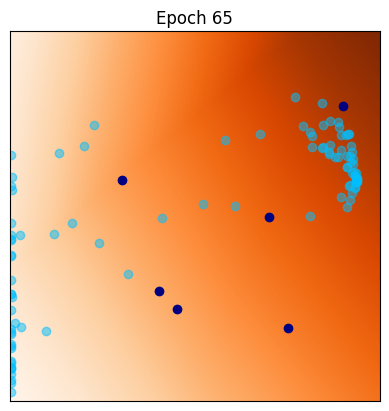

[66/100] 	Loss_D: -0.2715	Loss_G: -52.0870	Lip(D)=1.1210
[67/100] 	Loss_D: -0.2850	Loss_G: -41.6782	Lip(D)=1.0795
[68/100] 	Loss_D: -0.1181	Loss_G: -67.0917	Lip(D)=1.0858
[69/100] 	Loss_D: -0.2712	Loss_G: -30.6384	Lip(D)=1.1070
[70/100] 	Loss_D: -0.1983	Loss_G: -30.4464	Lip(D)=1.0527


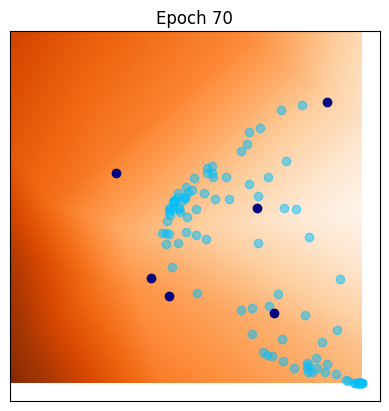

[71/100] 	Loss_D: -0.1719	Loss_G: -15.9060	Lip(D)=1.0933
[72/100] 	Loss_D: -0.2141	Loss_G: 0.0540	Lip(D)=1.0126
[73/100] 	Loss_D: -0.1983	Loss_G: -14.2119	Lip(D)=1.0385
[74/100] 	Loss_D: -0.1040	Loss_G: -28.8910	Lip(D)=1.0402
[75/100] 	Loss_D: -0.2302	Loss_G: -24.5370	Lip(D)=1.1071


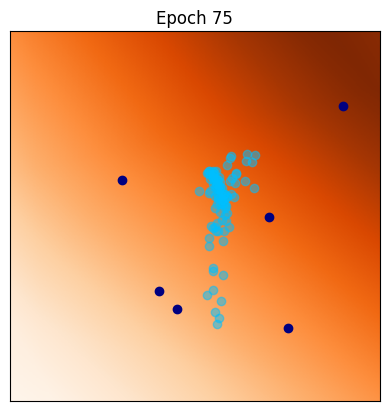

[76/100] 	Loss_D: -0.1984	Loss_G: -8.9449	Lip(D)=1.0710
[77/100] 	Loss_D: -0.3633	Loss_G: -16.7486	Lip(D)=1.1907
[78/100] 	Loss_D: -0.2176	Loss_G: -26.3258	Lip(D)=1.1102
[79/100] 	Loss_D: -0.1940	Loss_G: -40.6975	Lip(D)=0.9537
[80/100] 	Loss_D: -0.2445	Loss_G: -40.1098	Lip(D)=1.1057


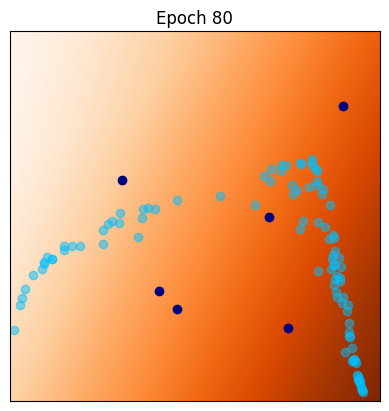

[81/100] 	Loss_D: -0.2339	Loss_G: -30.5514	Lip(D)=1.0775
[82/100] 	Loss_D: -0.1651	Loss_G: -33.5363	Lip(D)=1.0653
[83/100] 	Loss_D: -0.2602	Loss_G: -36.0580	Lip(D)=1.1148
[84/100] 	Loss_D: -0.2785	Loss_G: -37.0026	Lip(D)=1.1386
[85/100] 	Loss_D: -0.1891	Loss_G: -37.8381	Lip(D)=1.1124


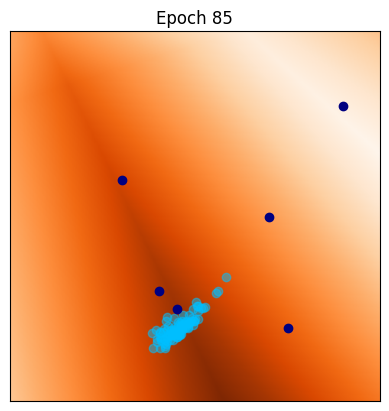

[86/100] 	Loss_D: -0.2887	Loss_G: -46.9786	Lip(D)=1.1317
[87/100] 	Loss_D: -0.3134	Loss_G: -40.7437	Lip(D)=1.1850
[88/100] 	Loss_D: -0.2928	Loss_G: -51.9223	Lip(D)=1.1129
[89/100] 	Loss_D: -0.1929	Loss_G: -64.2205	Lip(D)=0.9336
[90/100] 	Loss_D: -0.3419	Loss_G: -77.6750	Lip(D)=1.1755


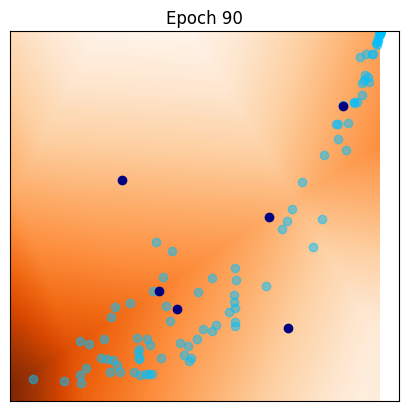

[91/100] 	Loss_D: -0.2754	Loss_G: -40.2757	Lip(D)=1.1602
[92/100] 	Loss_D: -0.1864	Loss_G: -63.7881	Lip(D)=1.0752
[93/100] 	Loss_D: -0.2913	Loss_G: -47.4634	Lip(D)=1.1718
[94/100] 	Loss_D: -0.1472	Loss_G: -43.9551	Lip(D)=1.0781
[95/100] 	Loss_D: -0.5647	Loss_G: -34.3720	Lip(D)=1.2464


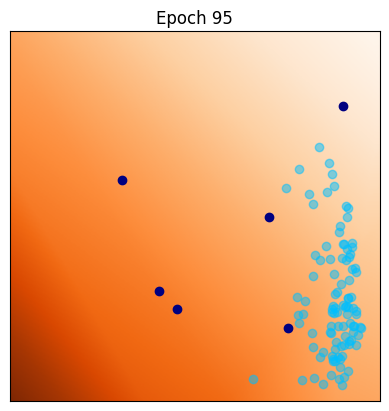

[96/100] 	Loss_D: -0.3497	Loss_G: -29.0590	Lip(D)=1.1268
[97/100] 	Loss_D: -0.3686	Loss_G: -20.6236	Lip(D)=1.1064
[98/100] 	Loss_D: -0.2811	Loss_G: -23.8886	Lip(D)=1.1271
[99/100] 	Loss_D: -0.1537	Loss_G: -0.0142	Lip(D)=1.0641


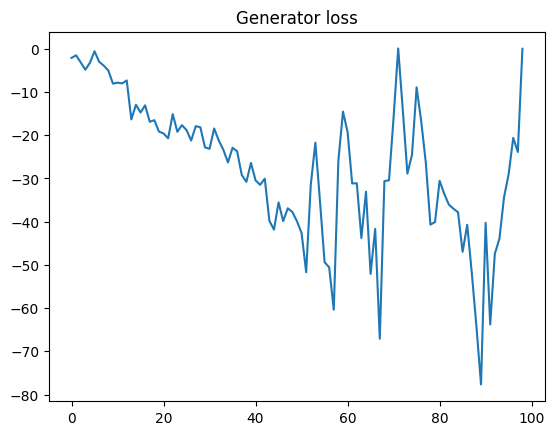

<All keys matched successfully>

In [19]:
## parameters for training
n_epochs = 100
niterD=1000
niterG=20
gpw = 1

lr = 0.01      # learning rate for generator
lrdisc = 0.002  # learning rate for discriminator
beta_1 = 0.5
beta_2 = 0.999


torch.manual_seed(1)  # initialize random seed for reproducibility

# Initialize generators and discriminators
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
optimG = optim.Adam(G.parameters(), lr=lr)

D = Discriminator(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))


Glosses = []
Dlosses = []

iter_display = 5

# Main loop
for epoch in range(1,n_epochs):

    ############################
    ### Train discriminator (niterD iterations)
    ############################

    for iter in range(0,niterD):
        optimD.zero_grad()

        z = torch.randn((b, n_in), device=device)
        x = G(z)
        gp = gradient_penalty(D, x.detach(), y)
        Dloss = -torch.mean(D(y)) + torch.mean(D(x.detach())) + gpw * gp

        Dloss.backward()
        optimD.step()

    ############################
    ### Train generator (niterG iterations)
    ############################
    for iter in range(0,niterG):
        optimG.zero_grad()

        z = torch.randn((b, n_in), device=device)
        x = G(z)
        Gloss = -torch.mean(D(x))

        Gloss.backward()
        optimG.step()

    # Output training stats
    print('[%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f\tLip(D)=%.4f'
      % (epoch, n_epochs, Dloss.item(), Gloss.item(),lipconstant(D,x,y).item()))
    Glosses.append(Gloss.item())
    Dlosses.append(Dloss.item())

    if(epoch % iter_display == 0):
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
        z = torch.randn(b, n_in, device=device)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Epoch '+str(epoch)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()


plt.figure(dpi=100)
plt.plot(Glosses)
plt.title('Generator loss')
plt.show()

# Save final generator for later use
wgan = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
wgan.load_state_dict(G.state_dict())

## Train the generator only

QUESTION: For a fixed discriminator, optimize only the generator only. Can you explain what is happening then?

[1/100] 	Loss_D: -0.1537	Loss_G: -0.0696	Lip(D)=0.0753
[2/100] 	Loss_D: -0.1537	Loss_G: -0.0756	Lip(D)=0.0753
[3/100] 	Loss_D: -0.1537	Loss_G: -0.0800	Lip(D)=0.0753
[4/100] 	Loss_D: -0.1537	Loss_G: -0.0886	Lip(D)=0.0753
[5/100] 	Loss_D: -0.1537	Loss_G: -0.0976	Lip(D)=0.0825


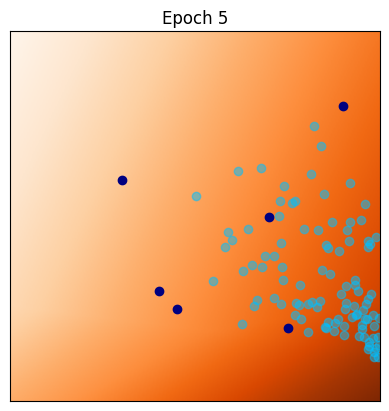

[6/100] 	Loss_D: -0.1537	Loss_G: -0.1047	Lip(D)=0.0850
[7/100] 	Loss_D: -0.1537	Loss_G: -0.1140	Lip(D)=0.1032
[8/100] 	Loss_D: -0.1537	Loss_G: -0.1193	Lip(D)=0.0971
[9/100] 	Loss_D: -0.1537	Loss_G: -0.1256	Lip(D)=0.1020
[10/100] 	Loss_D: -0.1537	Loss_G: -0.1284	Lip(D)=0.1202


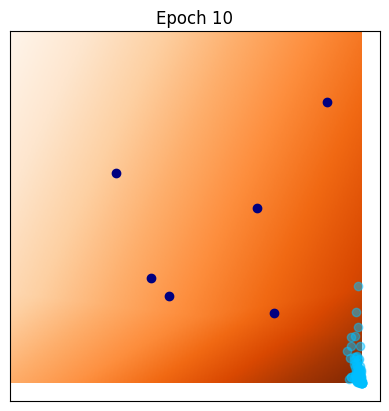

[11/100] 	Loss_D: -0.1537	Loss_G: -0.1303	Lip(D)=0.0960
[12/100] 	Loss_D: -0.1537	Loss_G: -0.1311	Lip(D)=0.1190
[13/100] 	Loss_D: -0.1537	Loss_G: -0.1315	Lip(D)=0.0995
[14/100] 	Loss_D: -0.1537	Loss_G: -0.1316	Lip(D)=0.1045
[15/100] 	Loss_D: -0.1537	Loss_G: -0.1320	Lip(D)=0.0850


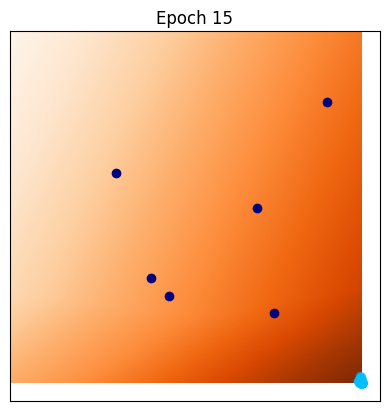

[16/100] 	Loss_D: -0.1537	Loss_G: -0.1322	Lip(D)=0.1154
[17/100] 	Loss_D: -0.1537	Loss_G: -0.1322	Lip(D)=0.1118
[18/100] 	Loss_D: -0.1537	Loss_G: -0.1323	Lip(D)=0.1045
[19/100] 	Loss_D: -0.1537	Loss_G: -0.1324	Lip(D)=0.1202
[20/100] 	Loss_D: -0.1537	Loss_G: -0.1324	Lip(D)=0.1263


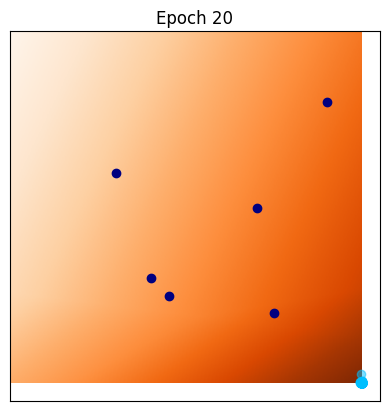

[21/100] 	Loss_D: -0.1537	Loss_G: -0.1325	Lip(D)=0.1118
[22/100] 	Loss_D: -0.1537	Loss_G: -0.1324	Lip(D)=0.0948
[23/100] 	Loss_D: -0.1537	Loss_G: -0.1325	Lip(D)=0.0923
[24/100] 	Loss_D: -0.1537	Loss_G: -0.1325	Lip(D)=0.1020
[25/100] 	Loss_D: -0.1537	Loss_G: -0.1325	Lip(D)=0.0923


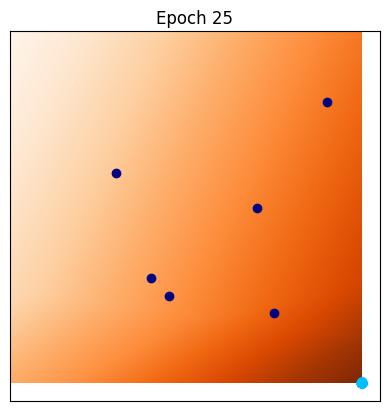

[26/100] 	Loss_D: -0.1537	Loss_G: -0.1325	Lip(D)=0.1142
[27/100] 	Loss_D: -0.1537	Loss_G: -0.1326	Lip(D)=0.1178
[28/100] 	Loss_D: -0.1537	Loss_G: -0.1326	Lip(D)=0.1020
[29/100] 	Loss_D: -0.1537	Loss_G: -0.1326	Lip(D)=0.1166
[30/100] 	Loss_D: -0.1537	Loss_G: -0.1326	Lip(D)=0.1142


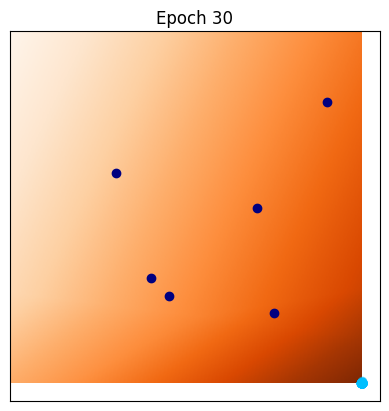

[31/100] 	Loss_D: -0.1537	Loss_G: -0.1326	Lip(D)=0.1057
[32/100] 	Loss_D: -0.1537	Loss_G: -0.1326	Lip(D)=0.0948
[33/100] 	Loss_D: -0.1537	Loss_G: -0.1326	Lip(D)=0.1118
[34/100] 	Loss_D: -0.1537	Loss_G: -0.1326	Lip(D)=0.1045
[35/100] 	Loss_D: -0.1537	Loss_G: -0.1326	Lip(D)=0.1154


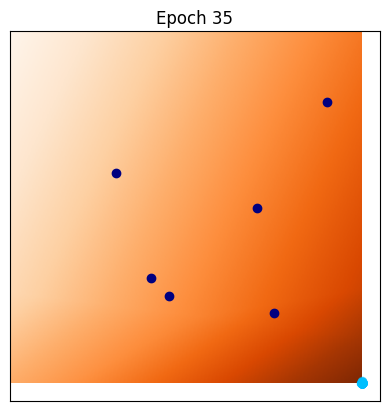

[36/100] 	Loss_D: -0.1537	Loss_G: -0.1326	Lip(D)=0.1057
[37/100] 	Loss_D: -0.1537	Loss_G: -0.1326	Lip(D)=0.0948
[38/100] 	Loss_D: -0.1537	Loss_G: -0.1326	Lip(D)=0.0948
[39/100] 	Loss_D: -0.1537	Loss_G: -0.1326	Lip(D)=0.0995
[40/100] 	Loss_D: -0.1537	Loss_G: -0.1326	Lip(D)=0.1264


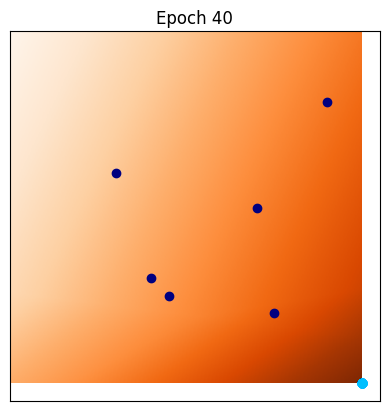

[41/100] 	Loss_D: -0.1537	Loss_G: -0.1326	Lip(D)=0.1045
[42/100] 	Loss_D: -0.1537	Loss_G: -0.1327	Lip(D)=0.1142
[43/100] 	Loss_D: -0.1537	Loss_G: -0.1327	Lip(D)=0.1105
[44/100] 	Loss_D: -0.1537	Loss_G: -0.1327	Lip(D)=0.1202
[45/100] 	Loss_D: -0.1537	Loss_G: -0.1327	Lip(D)=0.1045


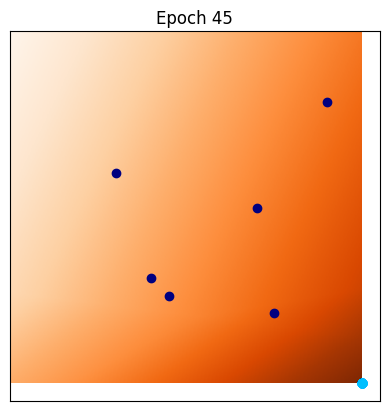

[46/100] 	Loss_D: -0.1537	Loss_G: -0.1327	Lip(D)=0.1215
[47/100] 	Loss_D: -0.1537	Loss_G: -0.1327	Lip(D)=0.1057
[48/100] 	Loss_D: -0.1537	Loss_G: -0.1327	Lip(D)=0.1227
[49/100] 	Loss_D: -0.1537	Loss_G: -0.1327	Lip(D)=0.0995
[50/100] 	Loss_D: -0.1537	Loss_G: -0.1327	Lip(D)=0.1215


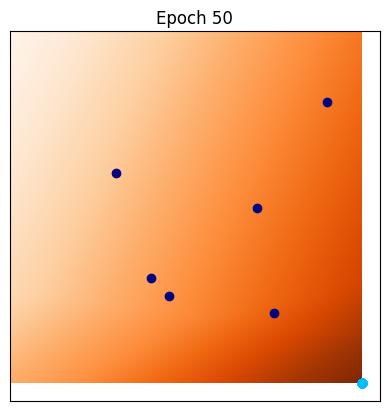

[51/100] 	Loss_D: -0.1537	Loss_G: -0.1327	Lip(D)=0.1215
[52/100] 	Loss_D: -0.1537	Loss_G: -0.1327	Lip(D)=0.1093
[53/100] 	Loss_D: -0.1537	Loss_G: -0.1327	Lip(D)=0.1057
[54/100] 	Loss_D: -0.1537	Loss_G: -0.1327	Lip(D)=0.1045
[55/100] 	Loss_D: -0.1537	Loss_G: -0.1327	Lip(D)=0.1142


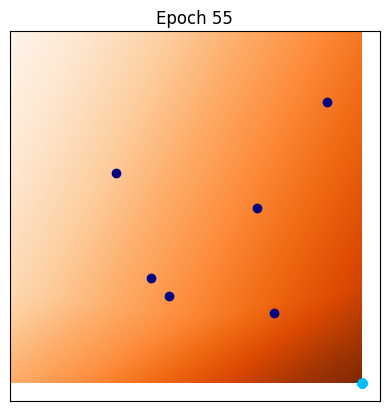

[56/100] 	Loss_D: -0.1537	Loss_G: -0.1327	Lip(D)=0.1093
[57/100] 	Loss_D: -0.1537	Loss_G: -0.1327	Lip(D)=0.1020
[58/100] 	Loss_D: -0.1537	Loss_G: -0.1327	Lip(D)=0.1178
[59/100] 	Loss_D: -0.1537	Loss_G: -0.1327	Lip(D)=0.1154
[60/100] 	Loss_D: -0.1537	Loss_G: -0.1327	Lip(D)=0.1142


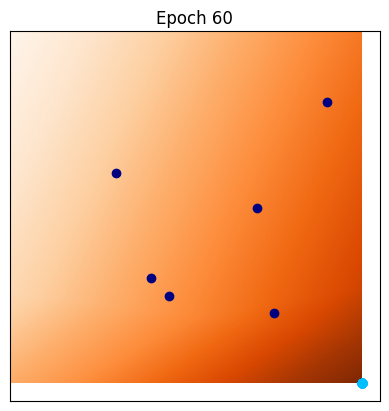

[61/100] 	Loss_D: -0.1537	Loss_G: -0.1327	Lip(D)=0.1045
[62/100] 	Loss_D: -0.1537	Loss_G: -0.1327	Lip(D)=0.1057
[63/100] 	Loss_D: -0.1537	Loss_G: -0.1327	Lip(D)=0.1130
[64/100] 	Loss_D: -0.1537	Loss_G: -0.1327	Lip(D)=0.1045
[65/100] 	Loss_D: -0.1537	Loss_G: -0.1327	Lip(D)=0.1032


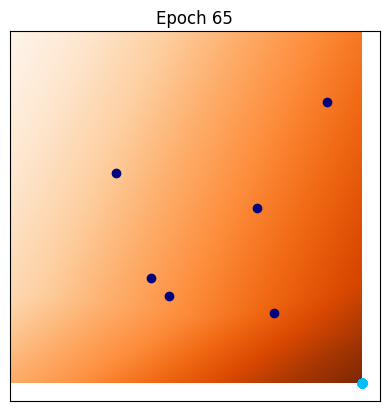

[66/100] 	Loss_D: -0.1537	Loss_G: -0.1327	Lip(D)=0.1190
[67/100] 	Loss_D: -0.1537	Loss_G: -0.1327	Lip(D)=0.0923
[68/100] 	Loss_D: -0.1537	Loss_G: -0.1327	Lip(D)=0.1118
[69/100] 	Loss_D: -0.1537	Loss_G: -0.1327	Lip(D)=0.1142
[70/100] 	Loss_D: -0.1537	Loss_G: -0.1327	Lip(D)=0.1093


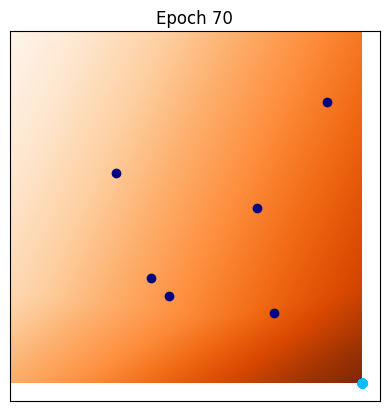

[71/100] 	Loss_D: -0.1537	Loss_G: -0.1327	Lip(D)=0.1118
[72/100] 	Loss_D: -0.1537	Loss_G: -0.1327	Lip(D)=0.1215
[73/100] 	Loss_D: -0.1537	Loss_G: -0.1327	Lip(D)=0.1130
[74/100] 	Loss_D: -0.1537	Loss_G: -0.1327	Lip(D)=0.1142
[75/100] 	Loss_D: -0.1537	Loss_G: -0.1327	Lip(D)=0.1190


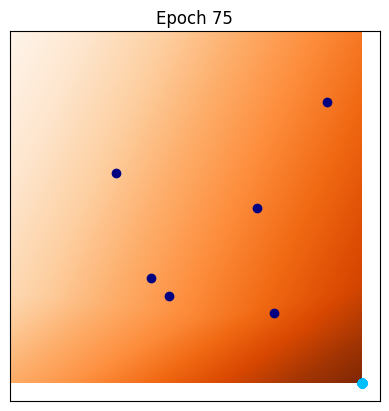

[76/100] 	Loss_D: -0.1537	Loss_G: -0.1327	Lip(D)=0.1190
[77/100] 	Loss_D: -0.1537	Loss_G: -0.1327	Lip(D)=0.1264
[78/100] 	Loss_D: -0.1537	Loss_G: -0.1327	Lip(D)=0.1227
[79/100] 	Loss_D: -0.1537	Loss_G: -0.1327	Lip(D)=0.1202
[80/100] 	Loss_D: -0.1537	Loss_G: -0.1327	Lip(D)=0.1154


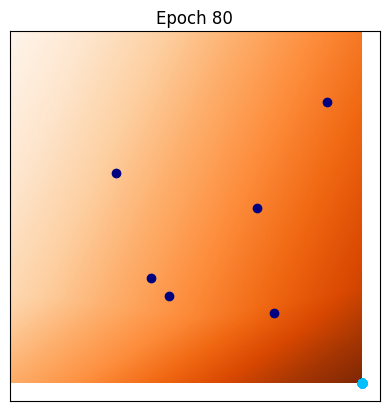

[81/100] 	Loss_D: -0.1537	Loss_G: -0.1327	Lip(D)=0.1165
[82/100] 	Loss_D: -0.1537	Loss_G: -0.1327	Lip(D)=0.1154
[83/100] 	Loss_D: -0.1537	Loss_G: -0.1327	Lip(D)=0.1165
[84/100] 	Loss_D: -0.1537	Loss_G: -0.1327	Lip(D)=0.1057
[85/100] 	Loss_D: -0.1537	Loss_G: -0.1327	Lip(D)=0.1045


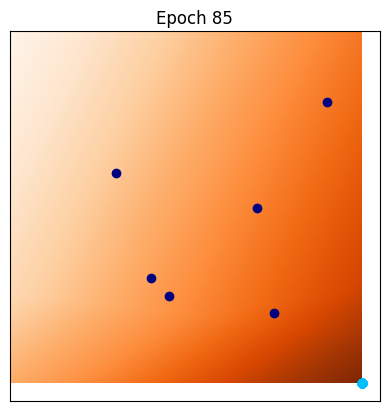

[86/100] 	Loss_D: -0.1537	Loss_G: -0.1327	Lip(D)=0.1118
[87/100] 	Loss_D: -0.1537	Loss_G: -0.1327	Lip(D)=0.1240
[88/100] 	Loss_D: -0.1537	Loss_G: -0.1327	Lip(D)=0.1105
[89/100] 	Loss_D: -0.1537	Loss_G: -0.1327	Lip(D)=0.0960
[90/100] 	Loss_D: -0.1537	Loss_G: -0.1327	Lip(D)=0.1130


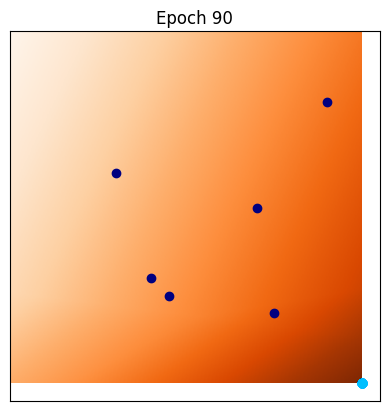

[91/100] 	Loss_D: -0.1537	Loss_G: -0.1327	Lip(D)=0.1227
[92/100] 	Loss_D: -0.1537	Loss_G: -0.1327	Lip(D)=0.1215
[93/100] 	Loss_D: -0.1537	Loss_G: -0.1327	Lip(D)=0.1020
[94/100] 	Loss_D: -0.1537	Loss_G: -0.1327	Lip(D)=0.1190
[95/100] 	Loss_D: -0.1537	Loss_G: -0.1327	Lip(D)=0.1239


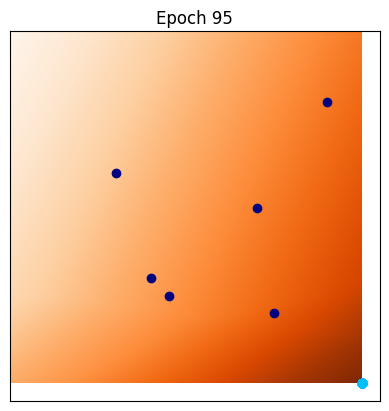

[96/100] 	Loss_D: -0.1537	Loss_G: -0.1327	Lip(D)=0.1032
[97/100] 	Loss_D: -0.1537	Loss_G: -0.1327	Lip(D)=0.1045
[98/100] 	Loss_D: -0.1537	Loss_G: -0.1327	Lip(D)=0.1240
[99/100] 	Loss_D: -0.1537	Loss_G: -0.1327	Lip(D)=0.1057


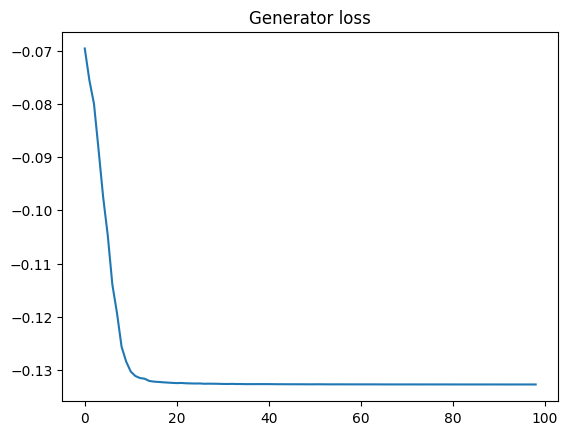

<All keys matched successfully>

In [20]:
## parameters for training
n_epochs = 100
niterD=1000
niterG=10
gpw = .1

lr = 0.002      # learning rate for generator
beta_1 = 0.5
beta_2 = 0.999

torch.manual_seed(1)  # initialize random seed for reproducibility

# Initialize generators and discriminators
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
optimG = optim.Adam(G.parameters(), lr=lr)

D = Discriminator(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))


Glosses = []
Dlosses = []

iter_display = 5

# Main loop
for epoch in range(1,n_epochs):

    ############################
    ### Train generator (niterG iterations)
    ############################
    for iter in range(0,niterG):
        optimG.zero_grad()

        z = torch.randn((b, n_in), device=device)
        x = G(z)
        Gloss = -torch.mean(D(x))

        Gloss.backward()
        optimG.step()

    # Output training stats
    print('[%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f\tLip(D)=%.4f'
      % (epoch, n_epochs, Dloss.item(), Gloss.item(),lipconstant(D,x,y).item()))
    Glosses.append(Gloss.item())
    Dlosses.append(Dloss.item())

    if(epoch % iter_display == 0):
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
        z = torch.randn(b, n_in, device=device)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Epoch '+str(epoch)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()


plt.figure(dpi=100)
plt.plot(Glosses)
plt.title('Generator loss')
plt.show()

# Save final generator for later use
wgan = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
wgan.load_state_dict(G.state_dict())

<br/><br/><br/><br/>

# BONUS Exercise (to do at home) : Learn a standard GAN

## Define Loss for GAN training

For stable GAN training uses the Binary cross-entropy loss which takes labeled data as input.

The data points $y$ should correspond to values $\approx 1$, whereas fake points $x$ should get values $\approx 0$.

We also introduce the sigmoid function. for displaying purpose: for GAN training, the discriminator values in $[0,1]$ will be obtained by applying after $D$.

In [ ]:
criterion = nn.BCEWithLogitsLoss()
V1 = torch.full((n,1), 1. , dtype=torch.float, device=device)
V0 = torch.full((b,1), 0. , dtype=torch.float, device=device)

sig = nn.Sigmoid()

## Train the discriminator for a fixed generator

QUESTION: Complete the following code at the blocks ###...###

In [ ]:
torch.manual_seed(1)  # initialize random seed for reproducibility

# parameters for discriminator optimization
lrdisc = 0.002
beta_1 = 0.5
beta_2 = 0.999
niterD=1000

# Initialize generators and discriminators
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
optimG = optim.Adam(G.parameters(), lr=lr)

D = Discriminator(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, 0.999))

iter_display = 100  # display current configuration each iter_display iteration

Dlosses = []

for iter in range(0,niterD):

    ### UPDATE OF D ###
    ### ... ###


    ### SAVE LOSS ###
    Dlosst = Dloss.item()
    Dlosses.append(-Dlosst)

    if(iter%iter_display == 0):
        print('[%d/%d], %f' % (iter, niterD, Dlosst))
        Dxgrid = sig(D(xgrid)).detach().cpu().numpy().reshape(nr,nc)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Iter '+str(iter)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)  # discriminator
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()


### Plot the evolution of the discriminator loss ###
plt.figure(dpi=100)
plt.plot(Dlosses)
plt.title('Discriminator loss')
plt.show()

## Train both the Generator and Discriminator

In [ ]:
lr = 0.002   # learning rate for generator
lrdisc = 0.002   # learning rate for generator

## parameters for training
n_epochs = 100
niterD=100
niterG=1

torch.manual_seed(1)  # initialize random seed for reproducibility

# Initialize generators and discriminators
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
optimG = optim.Adam(G.parameters(), lr=lr)

D = Discriminator(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))

Glosses = []
Dlosses = []

iter_display = 10

# Main loop
for epoch in range(n_epochs):

    ############################
    ### Train discriminator (niterD iterations)
    ############################
    for iter in range(0,niterD):
        ### ... ###

    ############################
    ### Train generator (niterG iterations)
    ############################
    for iter in range(0,niterG):
        ### ... ###


    # Output training stats
    print('[%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f'
      % (epoch, n_epochs, Dloss.item(), Gloss.item()))
    Glosses.append(Gloss.item())
    Dlosses.append(-Dloss.item())


    if(epoch % iter_display == 0):
        Dxgrid = sig(D(xgrid)).detach().cpu().numpy().reshape(nr,nc)
        z = torch.randn(b, 1, n_in, device=device)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Epoch '+str(epoch)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)  # discriminator
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()

# Save final generator for later use
gan = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
gan.load_state_dict(G.state_dict())

### Plot the evolution of the discriminator loss ###
plt.figure(dpi=100)
plt.plot(Glosses)
plt.title('Generator loss')
plt.show()